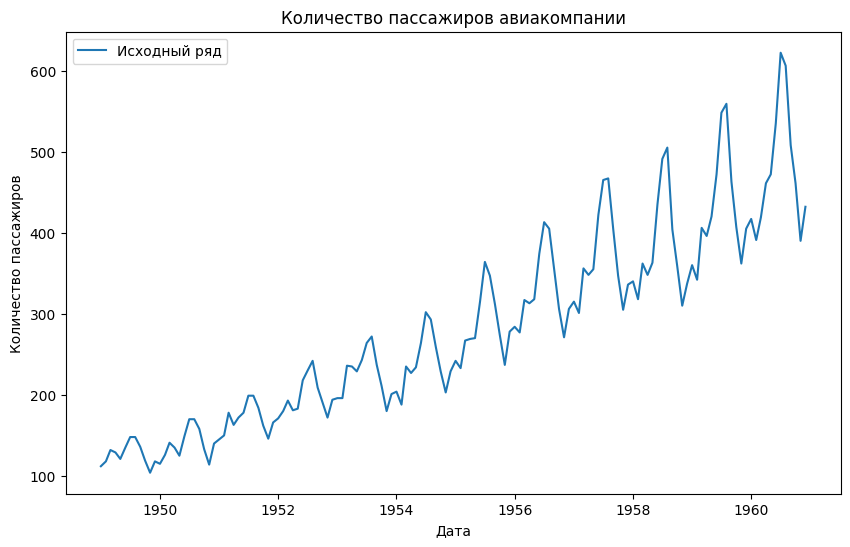

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima, ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                   index_col='Month', parse_dates=True)
data.columns = ['Passengers']

# Визуализация исходного ряда
plt.figure(figsize=(10, 6))
plt.plot(data['Passengers'], label='Исходный ряд')
plt.title('Количество пассажиров авиакомпании')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

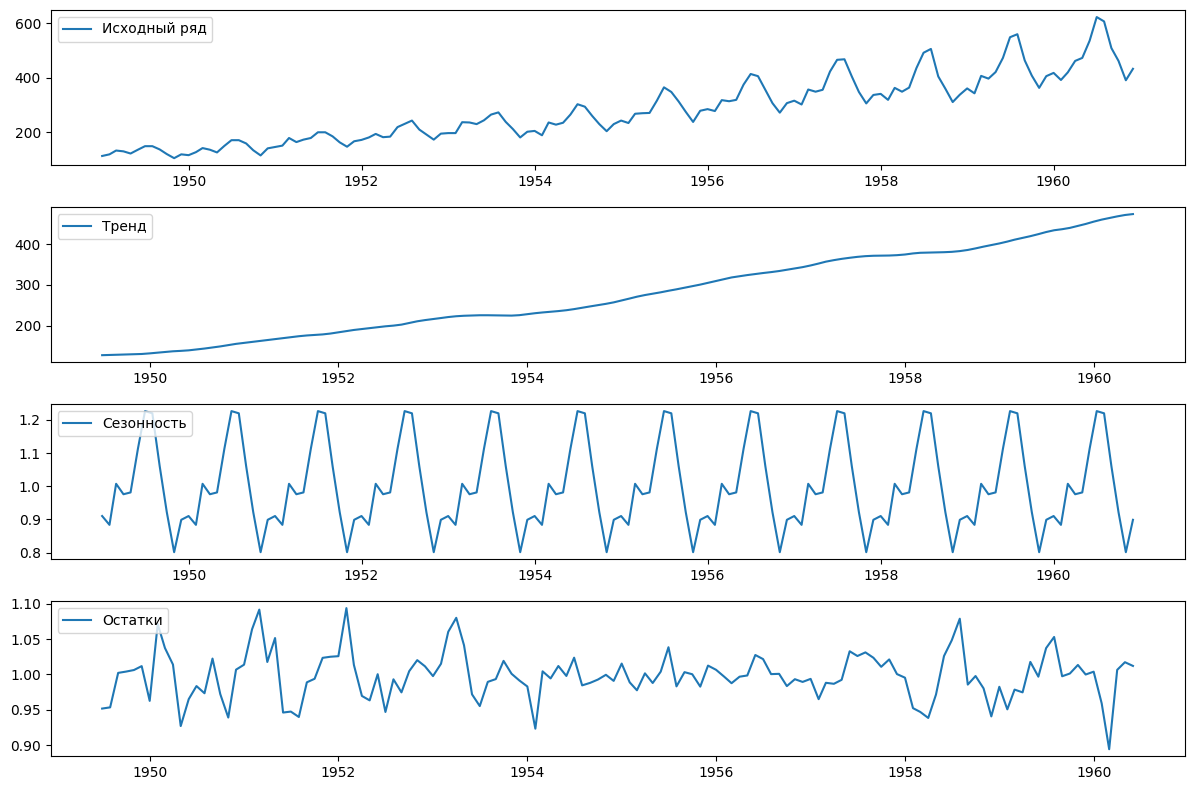

In [26]:
# Сезонная декомпозиция
decomposition = seasonal_decompose(data['Passengers'], model='multiplicative')

# Визуализация компонентов
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Исходный ряд')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Остатки')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

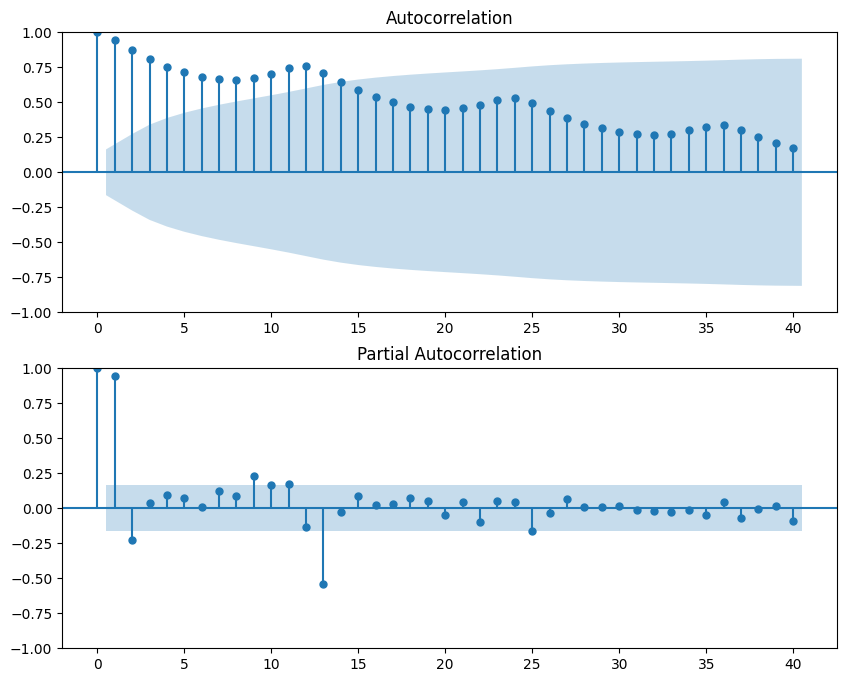

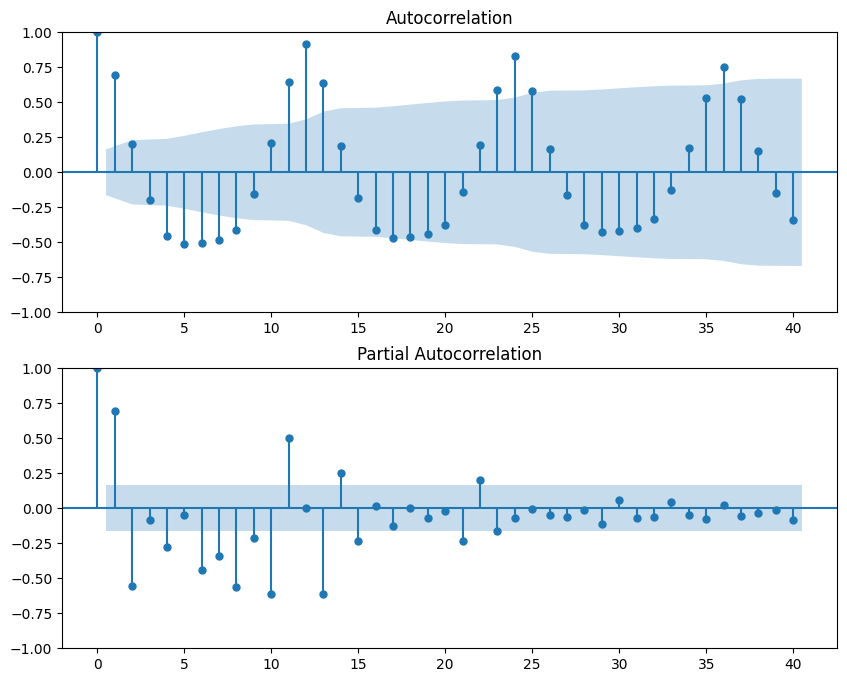

In [27]:
# ACF и PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(decomposition.observed, lags=40, ax=ax[0])
plot_pacf(decomposition.observed, lags=40, ax=ax[1])
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(decomposition.seasonal, lags=40, ax=ax[0])
plot_pacf(decomposition.seasonal, lags=40, ax=ax[1])
plt.show()

In [28]:
# Разделение данных
train = data[:'1959']
test = data['1960':]

In [29]:
# Подбор параметров ARIMA
model_arima = auto_arima(train, seasonal=True, m=6, trace=True, suppress_warnings=True)

# Обучение модели
model_arima.fit(train)

# Прогноз
forecast_arima = model_arima.predict(n_periods=len(test))

# Добавление прогноза в тестовую выборку
test['Forecast_ARIMA'] = forecast_arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=1134.035, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1277.589, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=1270.098, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=1266.084, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1276.259, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=1226.459, Time=0.80 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=1204.744, Time=0.96 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=1027.899, Time=1.42 sec
 ARIMA(2,1,2)(2,0,0)[6] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(2,1,2)(2,0,2)[6] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,1,2)(2,0,1)[6] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,1,1)(2,0,1)[6] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(3,1,2)(2,0,1)[6] intercept   : AIC=1030.949, Time=1.08 sec
 ARIMA(2,1,3)(2,0,1)[6] intercept   : AIC=1019.534, Time=1

In [30]:
# Обучение модели Хольта-Уинтерса
model_hw = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit()

# Прогноз
forecast_hw = model_hw.forecast(len(test))

# Добавление прогноза в тестовую выборку
test['Forecast_HW'] = forecast_hw

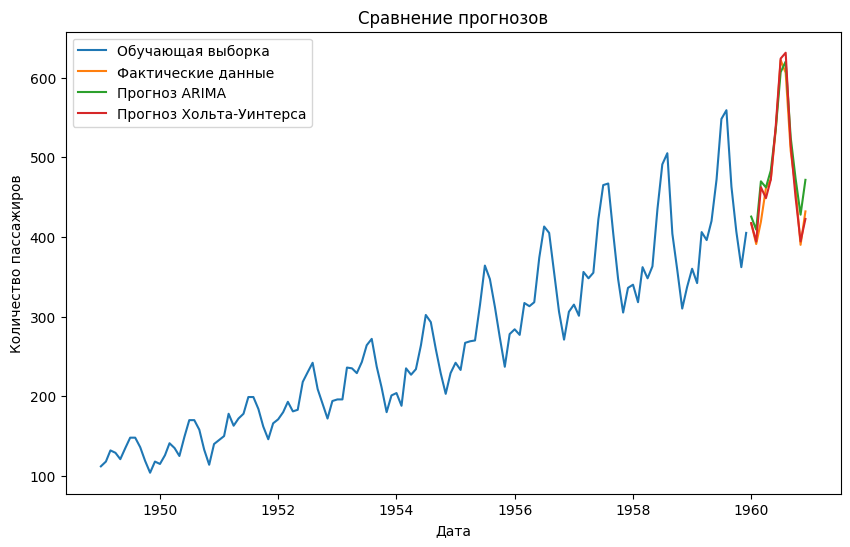

In [31]:
# Визуализация прогнозов
plt.figure(figsize=(10, 6))
plt.plot(train, label='Обучающая выборка')
plt.plot(test['Passengers'], label='Фактические данные')
plt.plot(test['Forecast_ARIMA'], label='Прогноз ARIMA')
plt.plot(test['Forecast_HW'], label='Прогноз Хольта-Уинтерса')
plt.title('Сравнение прогнозов')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

In [32]:
# RMSE для ARIMA
rmse_arima = np.sqrt(mean_squared_error(test['Passengers'], test['Forecast_ARIMA']))

# RMSE для Хольта-Уинтерса
rmse_hw = np.sqrt(mean_squared_error(test['Passengers'], test['Forecast_HW']))

print(f'RMSE ARIMA:             {rmse_arima:.3f}')
print(f'RMSE Хольта-Уинтерса:   {rmse_hw:.3f}')

RMSE ARIMA:             24.121
RMSE Хольта-Уинтерса:   15.807


In [33]:
def tune_arima_params(train, test, ms, start_p=0, max_p=5, start_d=0, max_d=2, start_q=0, max_q=5,
                      start_P=0, max_P=2, start_D=0, max_D=1, start_Q=0, max_Q=2):
    """
    Функция для тюнинга параметров ARIMA с использованием auto_arima и перебором сезонных периодов m.
    
    Параметры:
    - train: обучающая выборка
    - test: тестовая выборка
    - ms: список возможных сезонных периодов
    - start_p, max_p: начальное и максимальное значение для p (AR)
    - start_d, max_d: начальное и максимальное значение для d (I)
    - start_q, max_q: начальное и максимальное значение для q (MA)
    - start_P, max_P: начальное и максимальное значение для сезонного AR (P)
    - start_D, max_D: начальное и максимальное значение для сезонного I (D)
    - start_Q, max_Q: начальное и максимальное значение для сезонного MA (Q)
    
    Возвращает:
    - best_params: лучшие параметры (p, d, q, P, D, Q, m)
    - best_rmse: минимальное значение RMSE
    """
    best_rmse = float('inf')
    best_params = None
    
    # Перебор всех возможных сезонных периодов m
    for m in ms:
        try:
            # Автоматический подбор параметров ARIMA с текущим сезонным периодом m
            model = auto_arima(train, seasonal=True, m=m,
                               start_p=start_p, max_p=max_p,
                               start_d=start_d, max_d=max_d,
                               start_q=start_q, max_q=max_q,
                               start_P=start_P, max_P=max_P,
                               start_D=start_D, max_D=max_D,
                               start_Q=start_Q, max_Q=max_Q,
                               suppress_warnings=True, trace=True)
            model.fit(train)
            
            # Прогноз на тестовой выборке
            forecast = model.predict(n_periods=len(test))
            
            # Вычисление RMSE
            rmse = np.sqrt(mean_squared_error(test, forecast))
            
            # Обновление лучших параметров, если RMSE уменьшилось
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = model.get_params()  # Получаем параметры модели
                best_params['m'] = m  # Добавляем сезонный период m
        except:
            # Пропуск ошибок, связанных с нестабильностью модели
            continue
    
    return best_params, best_rmse


In [34]:
# Определение диапазонов для параметров
ms = [1,2,4,6,11,12]  # Сезонный период

# Тюнинг параметров
best_params, best_rmse = tune_arima_params(train['Passengers'], test['Passengers'], ms)

print(f"Лучшие параметры p, d, q, P, D, Q, m: {best_params['order'], best_params['seasonal_order']}")
print(f"Минимальное RMSE: {best_rmse:.3f}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 A

In [35]:
# Создание модели ARIMA с заданными параметрами
model = ARIMA(order=best_params['order'], seasonal_order=best_params['seasonal_order'])
# Обучение модели на тренировочных данных
model.fit(train)

# Прогнозирование на заданное количество периодов
forecast = model.predict(n_periods=len(test))
rmse = np.sqrt(mean_squared_error(test['Passengers'], forecast))

# Вывод прогноза
print(f'RMSE ARIMA:     {rmse:.3f}')

RMSE ARIMA:     18.536
